In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import torch
import torch.distributions as D

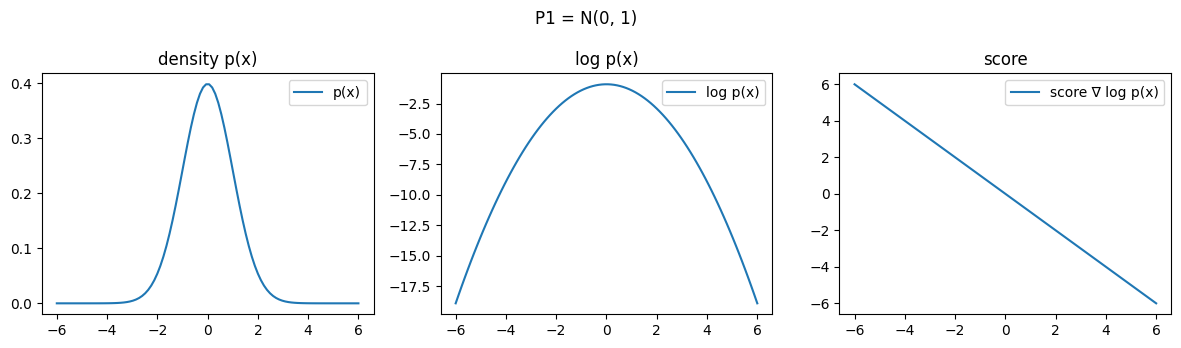

In [58]:
# B.1.1
mu = 0
variance = 1
sigma = math.sqrt(variance)


x = torch.linspace(-6, 6, 100, requires_grad=True)
dist = torch.distributions.Normal(mu, sigma)

log_p = dist.log_prob(x)
p = torch.exp(log_p)
score = torch.autograd.grad(log_p.sum(), x)[0]

# print('x: ', x)
# print('log_p: ', log_p)
# print('score: ', score)

x_np = x.detach().numpy()
log_p_np = log_p.detach().numpy()
score_np = score.detach().numpy()
p_np = p.detach().numpy()

plt.figure(figsize=(12, 3.5))

# p(x)
plt.subplot(1, 3, 1)
plt.plot(x_np, p_np, label="p(x)")
plt.title("density p(x)")
plt.legend()

# log p(x)
plt.subplot(1, 3, 2)
plt.plot(x_np, log_p_np, label="log p(x)")
plt.title("log p(x)")
plt.legend()

# score
plt.subplot(1, 3, 3)
plt.plot(x_np, score_np, label="score ∇ log p(x)")
plt.title("score")
plt.legend()

plt.suptitle("P1 = N(0, 1)")
plt.tight_layout()
plt.savefig('P1.png')
plt.show()


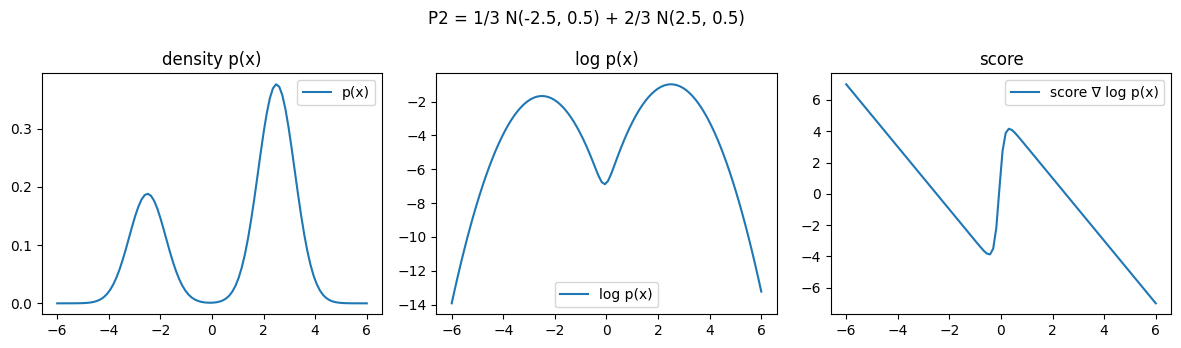

In [47]:
# B.1.2
mu1 = -2.5
variance1 = 0.5
sigma1 = math.sqrt(variance1)

mu2 = 2.5
variance2 = 0.5
sigma2 = math.sqrt(variance2)

x = torch.linspace(-6, 6, 100, requires_grad=True)
dist1 = torch.distributions.Normal(mu1, sigma1)
dist2 = torch.distributions.Normal(mu2, sigma2)

p1 = torch.exp(dist1.log_prob(x))
p2 = torch.exp(dist2.log_prob(x))

# p = 1/3 p1(x) + 2/3 p2(x)
p = 1/3 * p1 + 2/3 * p2
log_p = torch.log(p)
score = torch.autograd.grad(log_p.sum(), x)[0]

# print('x: ', x)
# print('log_p: ', log_p)
# print('score: ', score)

x_np = x.detach().numpy()
log_p_np = log_p.detach().numpy()
score_np = score.detach().numpy()
p_np = p.detach().numpy()

plt.figure(figsize=(12, 3.5))

# p(x)
plt.subplot(1, 3, 1)
plt.plot(x_np, p_np, label="p(x)")
plt.title("density p(x)")
plt.legend()

# log p(x)
plt.subplot(1, 3, 2)
plt.plot(x_np, log_p_np, label="log p(x)")
plt.title("log p(x)")
plt.legend()

# score
plt.subplot(1, 3, 3)
plt.plot(x_np, score_np, label="score ∇ log p(x)")
plt.title("score")
plt.legend()

plt.suptitle("P2 = 1/3 N(-2.5, 0.5) + 2/3 N(2.5, 0.5)")
plt.tight_layout()
plt.savefig('P2.png')
plt.show()


In [23]:
def score_matching_loss(model, x):
    score = model(x)    
    dsdx = torch.autograd.grad(score.sum(), x, create_graph=True)[0]
    loss = (score**2 + 2*dsdx).mean()
    return loss

In [ ]:
# B.2

n_iters = 6000
lr = 0.01
batch_size = 1000

mu = 0
variance = 1
sigma = math.sqrt(variance)
dist = torch.distributions.Normal(mu, sigma)

model = torch.nn.Sequential(
    torch.nn.Linear(1, 128),
    torch.nn.Softplus(),
    torch.nn.Linear(128, 128),
    torch.nn.Softplus(),
    torch.nn.Linear(128, 1)
)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)


for i in range(n_iters):
    
    x_batch = dist.sample((batch_size,)).view(batch_size, -1)
    x_batch.requires_grad_(True)
    
    loss = score_matching_loss(model, x_batch)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 1000 == 0:
        print(f"Iteration {i + 1}/{n_iters}, Loss: {loss.item():.6f}")
    


Iteration 1000/6000, Loss: -1.136142
Iteration 2000/6000, Loss: -1.011163
Iteration 3000/6000, Loss: -0.991748
Iteration 4000/6000, Loss: -0.975831
Iteration 5000/6000, Loss: -0.958022
Iteration 6000/6000, Loss: -1.033493


In [ ]:
# Grid as in the assignment
a = -6.0
n = 120
eps = 12.0 / n
x_grid_np = a + np.arange(n, dtype=np.float32) * eps
x_grid = torch.tensor(x_grid_np).unsqueeze(1)


Estimated E[||score_true - s_theta||^2]: 0.0075212093


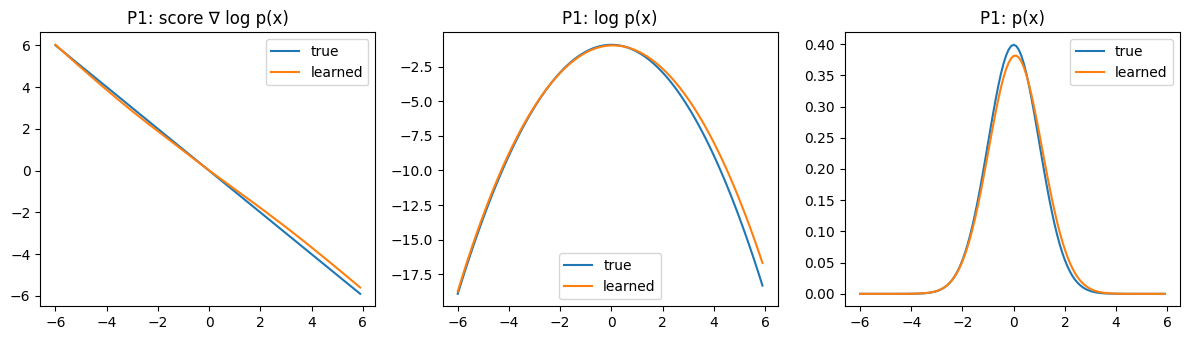

In [ ]:
with torch.no_grad():
    s_theta = model(x_grid).squeeze(1).cpu().numpy()

# Recover log p(x) from learned score by Riemann sum
log_p_rel = np.zeros(n)
log_p_rel[1:] = np.cumsum(s_theta[:-1] * eps)  # relative to x_0 = a

# approximate integral
numerator = np.exp(log_p_rel)
denominator = np.sum(numerator) * eps           
p_hat = numerator / denominator
log_p_hat = np.log(p_hat)

# Ground truth for P1
x_true = torch.tensor(x_grid_np, dtype=torch.float32, requires_grad=True)

log_p = dist.log_prob(x_true)
p = torch.exp(log_p)
score = torch.autograd.grad(log_p.sum(), x_true)[0]

log_p_true = log_p.detach().numpy()
p_true = p.detach().numpy()
score_true = score.detach().numpy()

# Expected Error
err_sq = (score_true - s_theta)**2
E_err = np.sum(eps * p_true * err_sq)
print("Estimated E[||score_true - s_theta||^2]:", E_err)

# ----- Plots -----
plt.figure(figsize=(12, 3.5))

plt.subplot(1, 3, 1)
plt.plot(x_grid_np, score_true, label="true")
plt.plot(x_grid_np, s_theta, label="learned")
plt.title("P1: score ∇ log p(x)")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(x_grid_np, log_p_true, label="true")
plt.plot(x_grid_np, log_p_hat, label="learned")
plt.title("P1: log p(x)")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(x_grid_np, p_true, label="true")
plt.plot(x_grid_np, p_hat, label="learned")
plt.title("P1: p(x)")
plt.legend()

plt.tight_layout()
plt.savefig('P1_learned.png')
plt.show()


In [37]:
mu1 = -2.5
variance1 = 0.5
sigma1 = math.sqrt(variance1)

mu2 = 2.5
variance2 = 0.5
sigma2 = math.sqrt(variance2)

dist1 = torch.distributions.Normal(mu1, sigma1)
dist2 = torch.distributions.Normal(mu2, sigma2)

model_P2 = torch.nn.Sequential(
    torch.nn.Linear(1, 128),
    torch.nn.Softplus(),
    torch.nn.Linear(128, 128),
    torch.nn.Softplus(),
    torch.nn.Linear(128, 1)
)
optimizer_P2 = torch.optim.Adam(model_P2.parameters(), lr=lr)

for i in range(n_iters):
    mix = torch.rand(batch_size, 1)
    x1 = dist1.sample((batch_size, 1))
    x2 = dist2.sample((batch_size, 1))
    x_batch = torch.where(mix < (1.0/3.0), x1, x2)
    x_batch.requires_grad_(True)

    loss = score_matching_loss(model_P2, x_batch)

    optimizer_P2.zero_grad()
    loss.backward()
    optimizer_P2.step()

    if (i + 1) % 1000 == 0:
        print(f"[P2] Iteration {i + 1}/{n_iters}, Loss: {loss.item():.6f}")


[P2] Iteration 1000/6000, Loss: -1.925123
[P2] Iteration 2000/6000, Loss: -2.023693
[P2] Iteration 3000/6000, Loss: -1.925678
[P2] Iteration 4000/6000, Loss: -2.137539
[P2] Iteration 5000/6000, Loss: -1.988547
[P2] Iteration 6000/6000, Loss: -2.009819


Estimated E[||score_true - s_theta||^2] for P2: 0.016519442


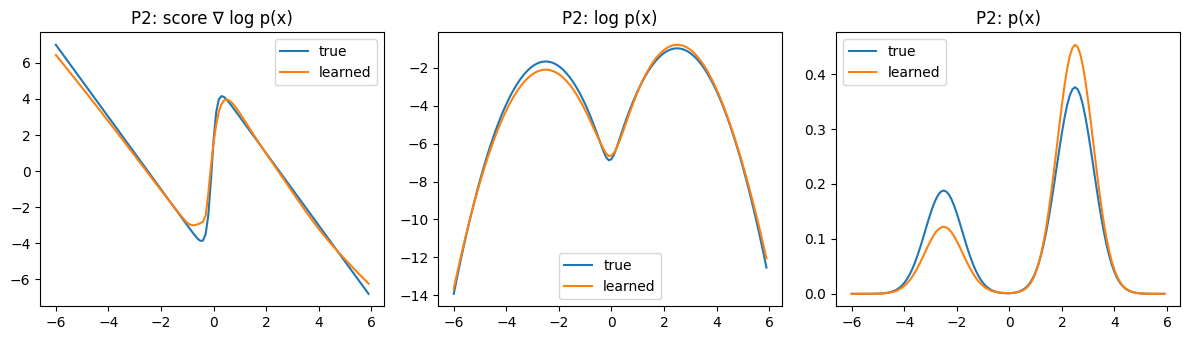

In [71]:
x_grid = torch.tensor(x_grid_np, dtype=torch.float32).unsqueeze(1)
with torch.no_grad():
    s_theta_P2 = model_P2(x_grid).squeeze(1).cpu().numpy()

# Recover log p(x) from learned score by Riemann sum
log_p_rel_P2 = np.zeros(n)
log_p_rel_P2[1:] = np.cumsum(s_theta_P2[:-1] * eps)
num_P2 = np.exp(log_p_rel_P2)
den_P2 = np.sum(num_P2) * eps
p_hat_P2 = num_P2 / den_P2
log_p_hat_P2 = np.log(p_hat_P2 + 1e-20)

# Ground truth for P2
x_true2 = torch.tensor(x_grid_np, dtype=torch.float32, requires_grad=True)

p1_true = torch.exp(dist1.log_prob(x_true2))
p2_true = torch.exp(dist2.log_prob(x_true2))
p_true_P2_torch = (1.0/3.0) * p1_true + (2.0/3.0) * p2_true
log_p_true_P2_torch = torch.log(p_true_P2_torch)

score_true_P2_torch = torch.autograd.grad(
    log_p_true_P2_torch.sum(), x_true2
)[0]

p_true_P2 = p_true_P2_torch.detach().numpy()
log_p_true_P2 = log_p_true_P2_torch.detach().numpy()
score_true_P2 = score_true_P2_torch.detach().numpy()

# Expected Error
err_sq_P2 = (score_true_P2 - s_theta_P2)**2
E_err_P2 = np.sum(eps * p_true_P2 * err_sq_P2)
print("Estimated E[||score_true - s_theta||^2] for P2:", E_err_P2)

# plots for P2
plt.figure(figsize=(12, 3.5))

plt.subplot(1, 3, 1)
plt.plot(x_grid_np, score_true_P2, label="true")
plt.plot(x_grid_np, s_theta_P2, label="learned")
plt.title("P2: score ∇ log p(x)")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(x_grid_np, log_p_true_P2, label="true")
plt.plot(x_grid_np, log_p_hat_P2, label="learned")
plt.title("P2: log p(x)")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(x_grid_np, p_true_P2, label="true")
plt.plot(x_grid_np, p_hat_P2, label="learned")
plt.title("P2: p(x)")
plt.legend()

plt.tight_layout()
plt.savefig('P2_learned.png')
plt.show()


In [ ]:
# P = 1/2 N(mu1, Sigma1) + 1/2 N(mu2, Sigma2)
mu1_2d = torch.tensor([3.0, 3.0])
mu2_2d = torch.tensor([-3.0, -3.0])

Sigma1_diag = torch.tensor([1.0, 0.5])
Sigma2_diag = torch.tensor([0.5, 0.5])

cov1_2d = torch.diag(Sigma1_diag)
cov2_2d = torch.diag(Sigma2_diag)

dist1_2d = D.MultivariateNormal(mu1_2d, covariance_matrix=cov1_2d)
dist2_2d = D.MultivariateNormal(mu2_2d, covariance_matrix=cov2_2d)

def sample_P_2d(batch_size):
    mix = torch.rand(batch_size, 1)
    x1 = dist1_2d.sample((batch_size,))   # [B,2]
    x2 = dist2_2d.sample((batch_size,))   # [B,2]
    x = torch.where(mix < 0.5, x1, x2)
    return x

mu1_np = np.array([3.0, 3.0])
mu2_np = np.array([-3.0, -3.0])
Sigma1_np = np.diag([1.0, 0.5])
Sigma2_np = np.diag([0.5, 0.5])
invSigma1_np = np.diag([1.0 / 1.0, 1.0 / 0.5])
invSigma2_np = np.diag([1.0 / 0.5, 1.0 / 0.5])
detSigma1 = np.linalg.det(Sigma1_np)
detSigma2 = np.linalg.det(Sigma2_np)

def pdf_gauss2d(xy, mu, invSigma, detSigma):
    diff = xy - mu  # [N,2]
    exponent = -0.5 * np.sum(diff @ invSigma * diff, axis=1)
    norm = 1.0 / (2.0 * np.pi * np.sqrt(detSigma))
    return norm * np.exp(exponent)

def score_gauss2d(xy, mu, invSigma):
    diff = xy - mu
    return -(diff @ invSigma)

def log_pdf_gauss2d(xy, mu, invSigma, log_detSigma):
    diff = xy - mu
    exponent = -0.5 * np.sum(diff @ invSigma * diff, axis=1)
    log_norm = -0.5 * (2 * np.log(2 * np.pi) + log_detSigma)
    return log_norm + exponent  # [N]

log_detSigma1 = np.log(np.linalg.det(Sigma1_np))
log_detSigma2 = np.log(np.linalg.det(Sigma2_np))

def mixture_score_2d(xy):
    # The numerical stable version
    log_p1 = log_pdf_gauss2d(xy, mu1_np, invSigma1_np, log_detSigma1)  # [N]
    log_p2 = log_pdf_gauss2d(xy, mu2_np, invSigma2_np, log_detSigma2)  # [N]

    log_w1 = np.log(0.5)
    log_w2 = np.log(0.5)

    a1 = log_w1 + log_p1
    a2 = log_w2 + log_p2

    # softmax to compute the contribution ratio
    m = np.maximum(a1, a2)
    exp1 = np.exp(a1 - m)
    exp2 = np.exp(a2 - m)
    Z = exp1 + exp2
    gamma1 = exp1 / Z      # [N]
    gamma2 = exp2 / Z      # [N]

    s1 = score_gauss2d(xy, mu1_np, invSigma1_np)  # [N,2]
    s2 = score_gauss2d(xy, mu2_np, invSigma2_np)  # [N,2]

    return gamma1[:, None] * s1 + gamma2[:, None] * s2  # [N,2]



In [ ]:
model_2d = torch.nn.Sequential(
    torch.nn.Linear(2, 128),
    torch.nn.Softplus(),
    torch.nn.Linear(128, 128),
    torch.nn.Softplus(),
    torch.nn.Linear(128, 2)
)

def score_matching_loss_2d(model, x):
    s = model(x)  # [B,2]
    term1 = (s**2).sum(dim=1)  # [B]

    # trace of Jacobian per sample
    trace = 0.0
    for i in range(2):
        grad_i = torch.autograd.grad(s[:, i].sum(), x, create_graph=True)[0][:, i]  # [B]
        trace = trace + grad_i

    loss = (term1 + 2.0 * trace).mean()
    return loss


In [50]:
n_iters_2d = 6000
lr_2d = 0.01
batch_size_2d = 1000

optimizer_2d = torch.optim.Adam(model_2d.parameters(), lr=lr_2d)

for i in range(n_iters_2d):
    x_batch = sample_P_2d(batch_size_2d)   # [B,2]
    x_batch.requires_grad_(True)

    loss = score_matching_loss_2d(model_2d, x_batch)

    optimizer_2d.zero_grad()
    loss.backward()
    optimizer_2d.step()

    if (i + 1) % 1000 == 0:
        print(f"[2D] Iteration {i + 1}/{n_iters_2d}, Loss: {loss.item():.6f}")


[2D] Iteration 1000/6000, Loss: -3.349410
[2D] Iteration 2000/6000, Loss: -3.489116
[2D] Iteration 3000/6000, Loss: -3.411628
[2D] Iteration 4000/6000, Loss: -3.345189
[2D] Iteration 5000/6000, Loss: -3.240160
[2D] Iteration 6000/6000, Loss: -3.379232


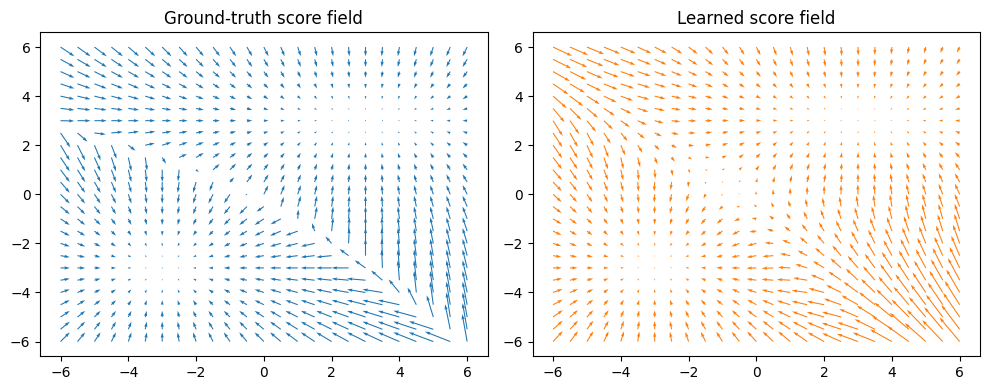

In [66]:
# create a grid in 2D
grid_lin = np.linspace(-6.0, 6.0, 25)
X, Y = np.meshgrid(grid_lin, grid_lin)   # [25,25] each

points = np.stack([X.ravel(), Y.ravel()], axis=1)  # [N,2], N = 25*25

# ground truth score on grid
score_true_2d = mixture_score_2d(points)           # [N,2]

# learned score on grid
points_t = torch.tensor(points, dtype=torch.float32)
with torch.no_grad():
    score_learned_2d = model_2d(points_t).cpu().numpy()  # [N,2]

U_true = score_true_2d[:, 0].reshape(X.shape)
V_true = score_true_2d[:, 1].reshape(Y.shape)
U_learn = score_learned_2d[:, 0].reshape(X.shape)
V_learn = score_learned_2d[:, 1].reshape(Y.shape)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.quiver(X, Y, U_true, V_true, color='C0')
plt.title("Ground-truth score field")

plt.subplot(1, 2, 2)
plt.quiver(X, Y, U_learn, V_learn, color='C1')
plt.title("Learned score field")

plt.tight_layout()
plt.savefig('P2D_learned.png')
plt.show()


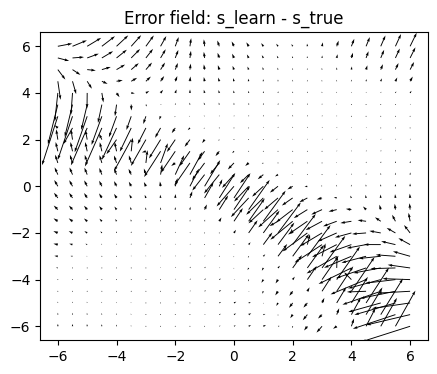

In [68]:
err_vec = score_learned_2d - score_true_2d      # [N,2]
U_err = err_vec[:, 0].reshape(X.shape)
V_err = err_vec[:, 1].reshape(Y.shape)

plt.figure(figsize=(5, 4))
plt.quiver(X, Y, U_err, V_err)
plt.title("Error field: s_learn - s_true")
plt.show()


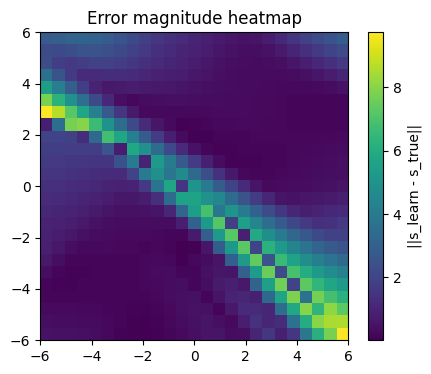

In [69]:
err_mag = np.linalg.norm(err_vec, axis=1).reshape(X.shape)

plt.figure(figsize=(5, 4))
plt.imshow(
    err_mag,
    origin='lower',
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    aspect='equal'
)
plt.colorbar(label="||s_learn - s_true||")
plt.title("Error magnitude heatmap")
plt.savefig('P2D_error.png')
plt.show()
